# 机器学习工程师纳米学位
## 深度学习
## 项目：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 连接 mnist 的字符来合成数据

你可以通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist

In [1]:
from keras.datasets import mnist

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

Using TensorFlow backend.


### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

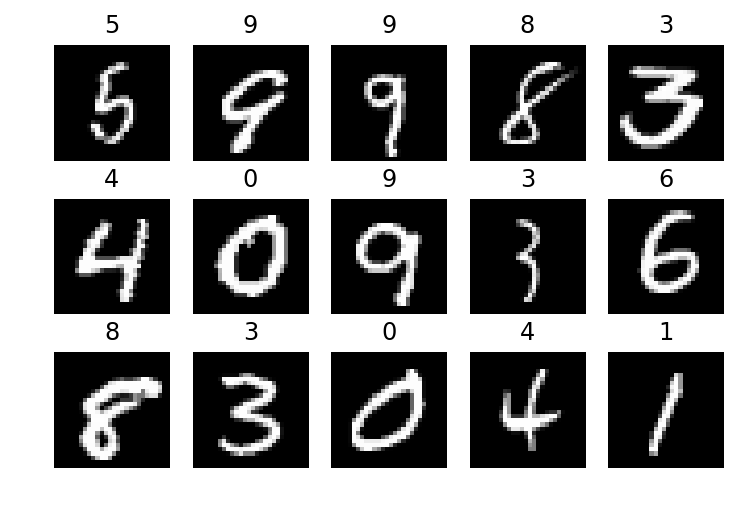

In [2]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 练习：合成数据

你需要随机取随机张图片，然后将它们拼接成新的图片。


In [48]:
import numpy as np

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    # 随机取1~5个数字，并拼接成新的图片
    for i in range(X_len):
        for j in range(n_len): 
            # 这里给定一个概率让空白取代数字
            if 9 < random.randint(0,11):
                y_gen[j][i][10] = 1
            else:    
                index = random.randint(0, X_len-1)
                X_gen[i,:,j*width:(j+1)*width, 0] = X[index]
                y_gen[j][i][y[index]] = 1
    return X_gen, y_gen
X_train, y_train = generate_dataset(X_raw, y_raw)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)
print(y_train[0].shape)

(60000, 11)


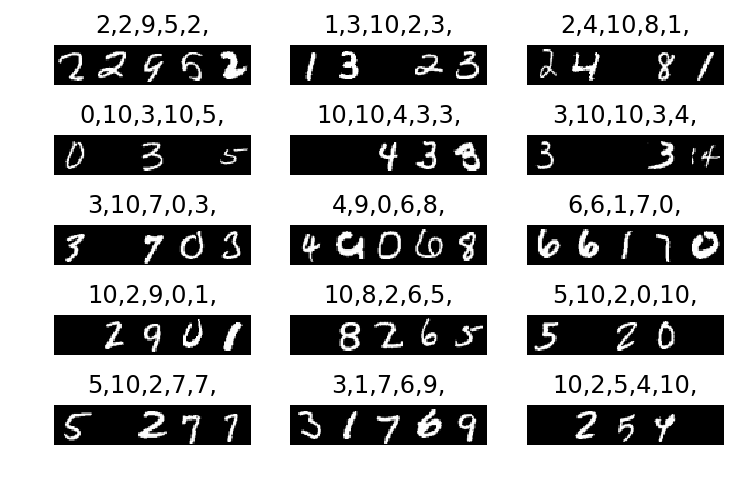

In [49]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

### 问题 1
_你是如何合成数据集的？_

**回答：**
通过两个循环
1. 外循环遍历了输入的的数据，如
```
X_train, y_train = generate_dataset(X_raw, y_raw)
```
这里的数据的大小就是len(X_raw)，外循环的次数也是这个。
2. 内循环的大小是5，因为根据题目，需要使用1-5个数字拼接合成一个图片。所以通过5次循环，每一次随机取一张图片
最后图片的矩阵由28x28变为为28x140。

### 练习：设计并测试一个模型架构

设计并实现一个能够识别数字序列的深度学习模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：

- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试是否在每个分类器间共享权值。
- 你还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

在使用 Keras 搭建模型的时候，你可以使用 [泛型模型](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [7]:
# 导入所需的模型

from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input, Dense

In [ ]:
def train_model(X_train, y_train):
    main_input = Input(shape=(28, 140, 1), name='main_input')
    # 卷积层
    x = Convolution2D(32, 3, 3, activation="relu")(main_input)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Convolution2D(32, 3, 3, activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Convolution2D(32, 3, 3 ,activation="relu")(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    # 分别训练5个数字
    y_out = [Dense(11, activation='softmax')(x) for i in range(n_len)]
    # 使用泛型输出5个数字的序列
    model = Model(input=main_input, output=y_out)
    model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, y_train, batch_size=1024, nb_epoch=8, shuffle=True, verbose=1, validation_split=0.2)
    return model
model = train_model(X_train, y_train)

Train on 48000 samples, validate on 12000 samples
Epoch 1/8
48000/48000 [==============================] - 20s - loss: 18.7552 - dense_71_loss: 4.0074 - dense_72_loss: 3.5357 - dense_73_loss: 3.5943 - dense_74_loss: 3.6799 - dense_75_loss: 3.9380 - dense_71_acc: 0.2999 - dense_72_acc: 0.4259 - dense_73_acc: 0.4128 - dense_74_acc: 0.4048 - dense_75_acc: 0.3229 - val_loss: 3.6914 - val_dense_71_loss: 0.9673 - val_dense_72_loss: 0.5942 - val_dense_73_loss: 0.6235 - val_dense_74_loss: 0.6091 - val_dense_75_loss: 0.8973 - val_dense_71_acc: 0.6931 - val_dense_72_acc: 0.8103 - val_dense_73_acc: 0.8015 - val_dense_74_acc: 0.8083 - val_dense_75_acc: 0.7130

### 问题 2
_你为解决这个问题采取了什么技术？请详细介绍你使用的技术。_

**回答：** 
1. 我的模型构造上，采用了卷积神经网络作为训练，最后一层全连接层作为分类输出
2. 为何使用卷积神经网络：首先这是图像识别方面的，如果是使用全连接的深度神经网络，这需要大量的权重进行训练，耗时而且容易过拟合。
卷积神经网络通过使用卷积核这个方法，让同一个卷积核内的图像共享权重，这样不仅减少了权重的数量，而且容易在每一层生成图像的某种模式如轮廓等
3. 为何使用max pool：我们可以使用增大stride来增大卷积核移动的步伐从而减少feature map，但是这样会丢失很多信息。在保持小的stride的前提下可以使用maxpool的技术进行优化，一样能减少feature map
4. 为何使用dropout：使用dropout，在前一层到后面一层之间(这里是训练的最后一层卷积和全连接层的输入)随机选择一部分设置为0，在实践中这种方法很好的防止过拟合

### 可视化你的网络模型

参考链接：[visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是 PNG 格式，也可以是 SVG 格式。

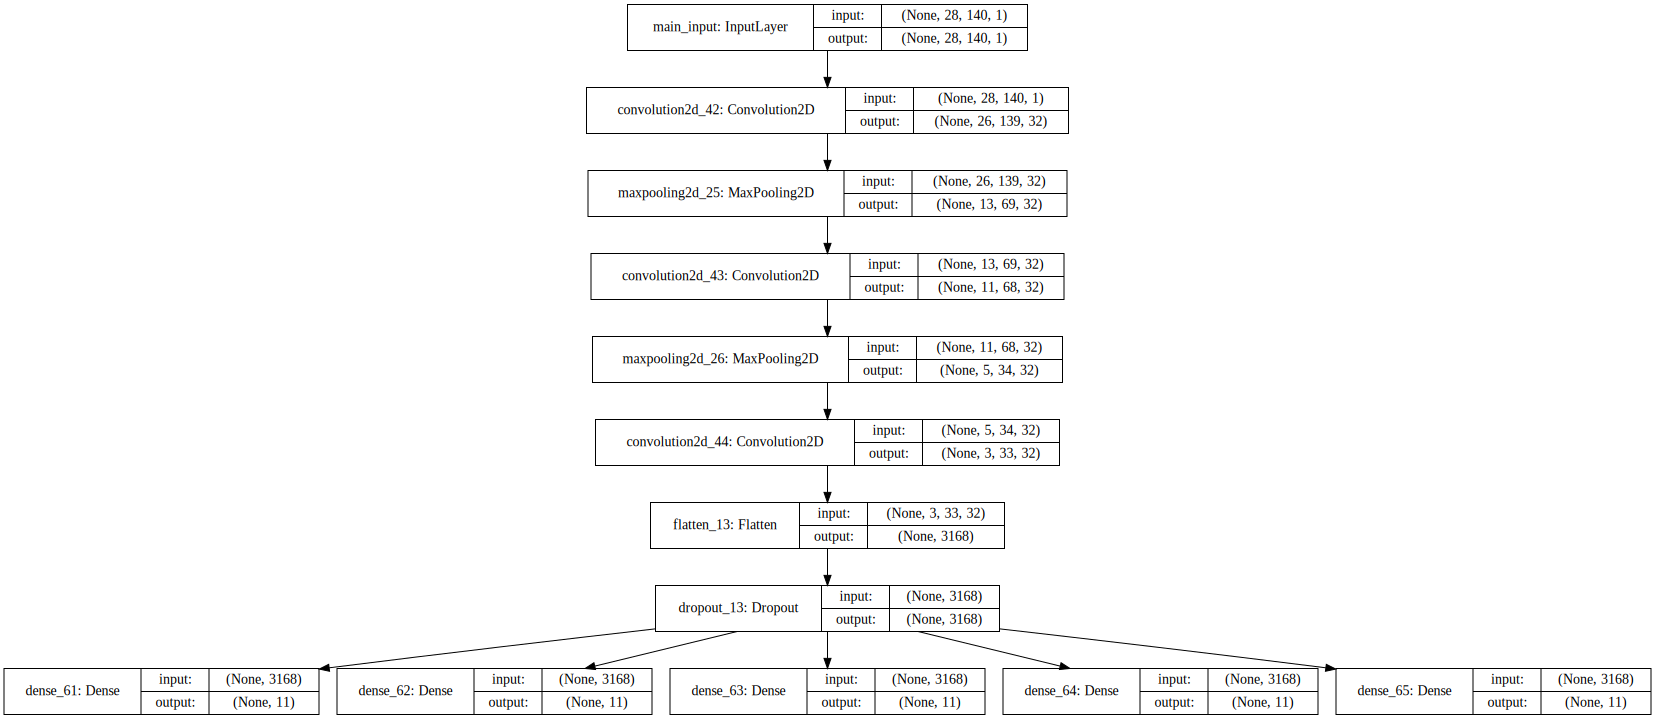

In [62]:
from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import Image, SVG
# 可视化网络模型
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


### 问题 3
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 如何连接等）_

**回答：**   
1. 使用了卷积神经网络结合全连接的神经网络
2. 层数总共10层。4层卷积，maxpool 2层，input,dropout,output和flaten各一层   
3. 连接顺序是input-cnn-maxpool-cnn-maxpool-cnn-cnn-dropout-flaten。然后分别5个1层的dense层，连接着flaten层

### 练习：训练你的网络模型

你需要设置20%的数据作为验证集，以保证模型没有过拟合。

### 练习：计算你的模型准确率

我们刚才得到了模型每个数字的准确率，现在让我们来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [67]:
# 测试模型
prediction = model.predict(X_test)

In [68]:
# 计算测试集中数字序列的准确率
def evaluate(model):
    right = 0
    error = 0
    for i in range (1000):
        right_num = 0
        for j in range(5):
            y_pred_num = np.argmax(prediction[j][i])
            y_test_num = np.argmax(y_test[j][i])
            if y_pred_num == y_test_num:
                right_num += 1
        if right_num == 5:
            right += 1
        else:
            error += 1
    
    return float(right)/(right+error)

evaluate(model)

0.945

### 问题 4

_你的模型准确率有多少？你觉得你的模型足以解决问题吗？_

**回答：**
模型的准确率达到0.945。我觉得还是足以解决问题的。

### 预测值可视化

我们将模型的预测结果和真实值画出来，观察真实效果。

(-0.5, 139.5, 27.5, -0.5)

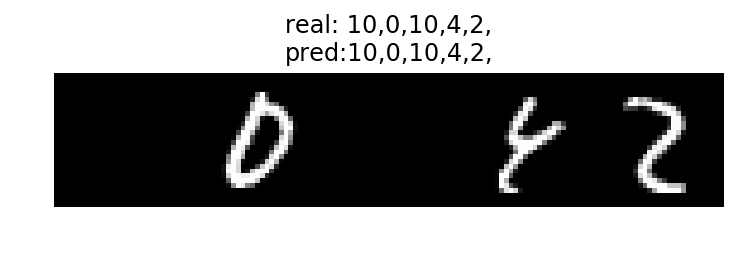

In [54]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)
y_pred = model.predict(X_test[index].reshape(1, height, width*n_len, 1))

plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，我们需要将模型的权值和结构保存，以便下次调用。

In [55]:
model.save_weights('model.h5')
with open('model.json', 'w') as f:
    f.write(model.to_json())